<a href="https://colab.research.google.com/github/Leerish/Deep-Learning-Notebooks/blob/main/Transfer_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning


## Creating Helper Functions
Importing Helper Functions from a github repository , it's a good idea to put the functions in a separate script file in github and import them when needed



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-03 14:32:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-03 14:32:44 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Importing helper functions

from helper_functions import create_tensorboard_callback , plot_loss_curves, unzip_data,walk_through_dir

##  Let's Get some Data
This time we are going to use pretrained models within `tf.keras.applications` and apply to our problem

In [ ]:
# Get 10% of training data of 10 classes of Food101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-12-03 14:32:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   203MB/s    in 0.8s    

2023-12-03 14:32:50 (203 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are there in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths

train_dir ="10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode ="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir ,
                                                                image_size = IMG_SIZE,
                                                                label_mode ="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images , labels in train_data_10_percent.take(1): #take(1) --> take one batch
  print(images , labels)

tf.Tensor(
[[[[193.11224    80.69898   126.0102   ]
   [194.7602     84.94898   129.02551  ]
   [189.63776    84.35714   124.86224  ]
   ...
   [181.38776    78.74496   116.94899  ]
   [182.26534    80.31636   117.29084  ]
   [180.7498     81.821236  115.923256 ]]

  [[188.90816    82.71939   123.168365 ]
   [191.84694    85.79082   125.77551  ]
   [193.         86.78571   124.85714  ]
   ...
   [183.6889     79.21951   119.132774 ]
   [180.70918    81.20412   118.994896 ]
   [182.35704    87.97442   121.99482  ]]

  [[186.42346    84.78061   117.85204  ]
   [192.38776    86.53062   122.88776  ]
   [195.95409    87.40306   124.21429  ]
   ...
   [174.37766    87.52551   126.1429   ]
   [177.82654    86.57144   124.42856  ]
   [174.87227    84.657974  120.00997  ]]

  ...

  [[206.92346   229.92346   243.92346  ]
   [209.92857   231.92857   245.92857  ]
   [211.        233.        247.       ]
   ...
   [113.806274  126.23486   126.44916  ]
   [140.38284   152.81143   152.81143  ]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is a straight forward apporach , it runs our layers in sequnetial order.

But the Functional API gives us more flexibility with our models.


In [ ]:
#1.Create base model with tf.keras.applications

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

# 2. Freeze the base model layers (so underlying pre-trained patterns aren't updated during training)

base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224 , 224 , 3) , name ="input_layer")

# 4. If using ResNet50V2 you will need to normalize the input (not needed for efficientnetV2)

# 5. Pass the inputs to base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model :{x.shape}")

# 6. Average pool the outputs of the base model(aggregate all the most important information, reduce the number of computations)

x = tf.keras.layers.GlobalAveragePooling2D( name = "global_average_pooling")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer

outputs = tf.keras.layers.Dense(10 , activation = "softmax" , name="output_layer")(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs , outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

#10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
            epochs = 5 ,
            steps_per_epoch =len(train_data_10_percent),
            validation_data = test_data,
            validation_steps=(0.25*len(test_data)),
            callbacks=[create_tensorboard_callback("transfer_learning" , experiment_name="10_percent_feature_exteaction")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after passing inputs through base model :(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_exteaction/20231203-143312
Epoch 1/5
24/24 [==============================] - 24s 287ms/step - loss: 1.8565 - accuracy: 0.4240 - val_loss: 1.3303 - val_accuracy: 0.7359
Epoch 2/5
24/24 [==============================] - 4s 157ms/step - loss: 1.1233 - accuracy: 0.7613 - val_loss: 0.9022 - val_accuracy: 0.7969
Epoch 3/5
24/24 [==============================] - 5s 161ms/step - loss: 0.8266 - accuracy: 0.8173 - val_loss: 0.7069 - val_accuracy: 0.8375
Epoch 4/5
24/24 [==============================] - 5s 175ms/step - loss: 0.6774 - accuracy: 0.8493 - val_loss: 0.6365 - val_accuracy: 0.8359
Epoch 5/5
24/24 [==============================] - 4s 172ms/step - loss: 0.5864 - accuracy: 0.8720 - val_loss: 0.5681 - val_accuracy: 0.8562


In [ ]:
# Evaluate on full test_data
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.5623 - accuracy: 0.8584


[0.5623407959938049, 0.8583999872207642]

In [ ]:
# Check layers in base layer
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

In [ ]:
# Summary of base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
#Summary of whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


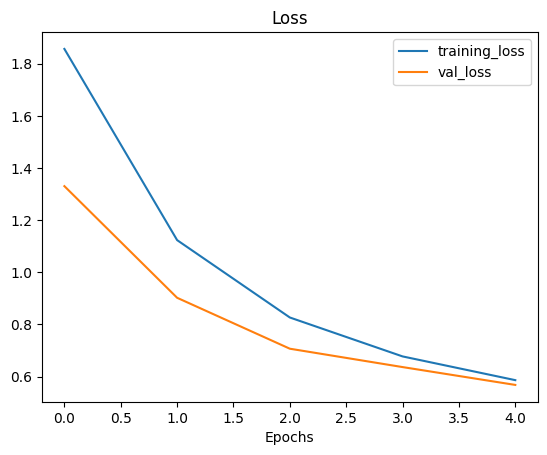

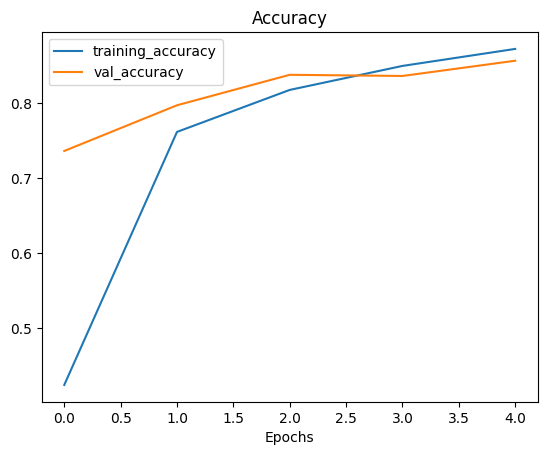

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting Feature Vector from a trained model

Demonstrating Global Average Pooling 2D layer

we have a tensor after our model goes through `base_model` of shape (None , 7 ,7 ,1280).

But then when it passes through GlobalAveragePooling2D , it turns into (None,1280).

Let's use a similar shaped tensor of(1,4,4,3) and then pass it to GlobalAveragePooling2D (Transforms a 4D Tensor to 2D Tensor)


In [ ]:
# Define The input Shape

input_shape = (1,4,4,3)

# Create a random Tensor
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f"Random Input Tensor:\n{input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_layer = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_layer}\n")

Random Input Tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]



In [ ]:
global_layer.shape

TensorShape([1, 3])

In [ ]:
input_tensor.shape

TensorShape([1, 4, 4, 3])

In [ ]:
# Let's Replicate the GlobalAveragePool2D layer

tf.reduce_mean(input_tensor , axis=[1 ,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
global_layer_2 = tf.keras.layers.GlobalMaxPool2D()(input_tensor)

In [ ]:
global_layer_2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments

Testing our models with 1 % percent of total data using transfer learning

1. model_1 - use feature extraction transfer learning with 1% of the training data with data augmentation

2. model_2 - use feature extraction transfer learning with 10% training data with data augmentation

3. model_3 - use fine tuning transfer learning on 10% of the training data with data augmentation

4. model_4 - use fine-tuning transfer learning on 100% of training data with data augmentation

>**Note:** Throughout all experiments the same test dataset will be used to evaluate our model. This ensures consistency across our evaluation metrics

## Getting and Preprocessing data for Model 1

In [ ]:
# Download the unzip data - preprocessed from food 101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-12-03 10:51:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  22.1MB/s    in 6.8s    

2023-12-03 10:51:40 (18.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test directories

train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
# How many images are we working with

walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [ ]:
# Setup data loaders

IMG_SIZE =(224 , 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode ="categorical",
                                                                           batch_size = 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size =32)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation
To Add Data Augmentation right into our models , we can use the layers inside:
* tf.keras.layers.experimental.preprocessing()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping , rotations , zooms , etc
data_aug = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),

],name="data_augmentation")

### Visualize the data augmentation layer

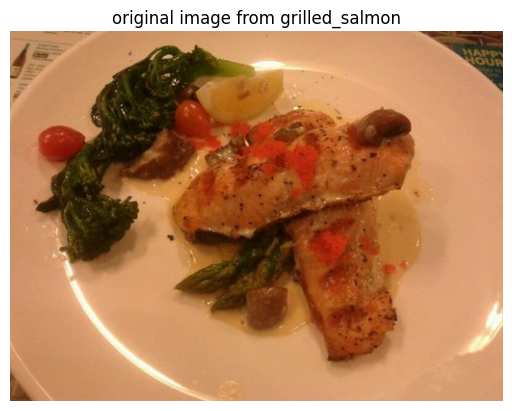

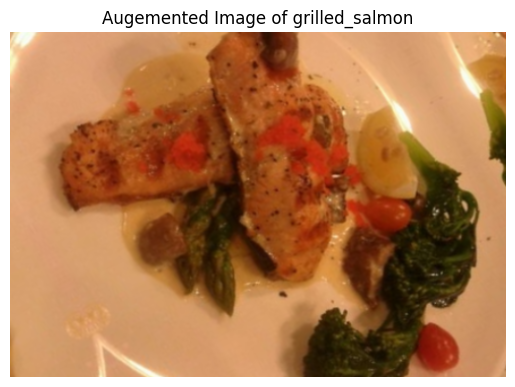

In [ ]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = train_dir_1_percent + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image

#Read in the random image
img = mpimg.imread(random_image_path)
plt.title(f"original image from {target_class}")
plt.axis(False);
plt.imshow(img)

# Now Let's plot  augmented image
plt.figure()
aug_img = data_aug(tf.expand_dims(img, axis=0) , training=True)
plt.title(f"Augemented Image of {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(aug_img)/255.);

## Model 1 : Feature Extraction Transfer Learning on 1% of data with data augmentation

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create Input Layer
inputs = layers.Input(shape = input_shape , name ="input_layer")

# Add in data augmentation Sequential model as a layer

x = data_aug(inputs)

# Give base model the inputs and don't train it
x= base_model(x , training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output layer
outputs = layers.Dense(10 , activation="softmax" , name ="output_layer")(x)

# Make a model using the inputs and outputs
model_1  = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics =["accuracy"])
# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs = 5 ,
                        steps_per_epoch = len(train_data_1_percent),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        callbacks=[create_tensorboard_callback("transfer_learning" , experiment_name ="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231203-072258
Epoch 1/5
3/3 [==============================] - 16s 4s/step - loss: 2.3751 - accuracy: 0.0714 - val_loss: 2.2681 - val_accuracy: 0.1540
Epoch 2/5
3/3 [==============================] - 8s 4s/step - loss: 2.1948 - accuracy: 0.2286 - val_loss: 2.1534 - val_accuracy: 0.2484
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9830 - accuracy: 0.3429 - val_loss: 2.0537 - val_accuracy: 0.3296
Epoch 4/5
3/3 [==============================] - 8s 4s/step - loss: 1.8466 - accuracy: 0.5000 - val_loss: 1.9631 - val_accuracy: 0.3900
Epoch 5/5
3/3 [==============================] - 9s 4s/step - loss: 1.6888 - accuracy: 0.6429 - val_loss: 1.8753 - val_accuracy: 0.4336


In [ ]:
# Checkout our model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [ ]:
# Evaluate on full test data
result_1 = model_1.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 1.8753 - accuracy: 0.4336


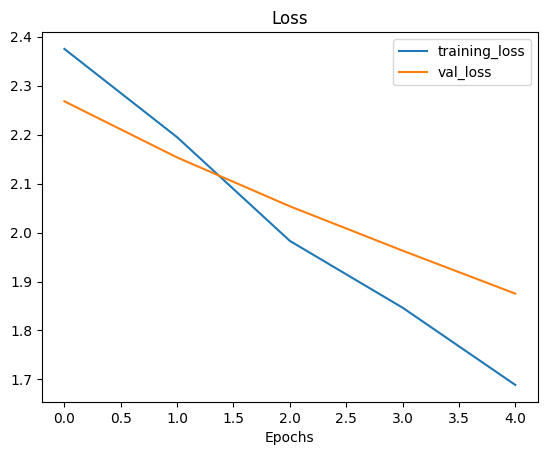

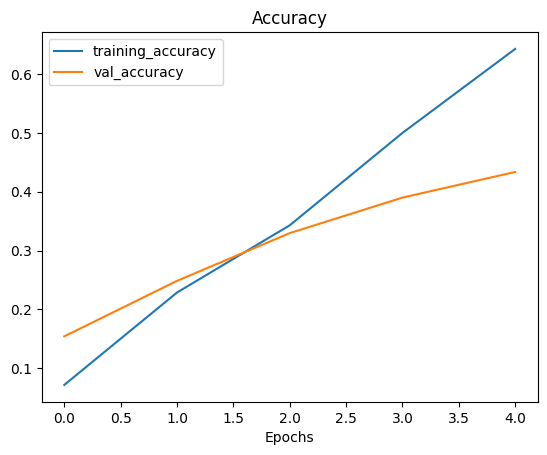

In [ ]:
#Plot loss curves
plot_loss_curves(history_1)

## Model 2 : Feature Extraction Transfer Learning Model with 10% of data with data augmentation

In [ ]:
# Download Data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-12-03 10:51:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  22.2MB/s    in 8.6s    

2023-12-03 10:52:08 (18.7 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Create Train and Test Directories
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


In [ ]:
# Create data loaders
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode = "categorical",
                                                                    batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Exploring data
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create model 2

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_aug = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
] , name="data_augmentation")

# Setup input shape

input_shape =(224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False


# Create the inputs and outputs
inputs = layers.Input(shape = input_shape ,name = "input_layer")
x = data_aug(inputs)
x = base_model( x , training=False ) # we pass the augmented images but keep the model in inference mode , this also ensures batch norm doesn't get updated
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
outputs = layers.Dense(10 , activation = "softmax" , name = "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Creating a model checkpoint callback

The ModelCheckPoint callback intermediately saves our model (the full model or just the weights) during training .This is useful so we can come and start where we left off.

In [ ]:
# Set Checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose = 1)

In [ ]:
initial_epochs = 5

In [ ]:
### Fit Model 2 passing in the ModelCheckpoint callback


history_10_percent_data_aug = model_2.fit(train_data_10,
                                          epochs = initial_epochs ,
                                          validation_data = test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name="transfer_learning" , experiment_name="10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231203-144532
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0358 - accuracy: 0.3280
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 28s 837ms/step - loss: 2.0358 - accuracy: 0.3280 - val_loss: 1.5275 - val_accuracy: 0.5987
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4030 - accuracy: 0.6347
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 610ms/step - loss: 1.4030 - accuracy: 0.6347 - val_loss: 1.0662 - val_accuracy: 0.7549
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1103 - accuracy: 0.7227
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 609ms/step - loss: 1.1103 - accuracy: 0.7227 - val_loss: 0.8853 - val_accuracy: 0.7763
E

In [ ]:
result_2 = model_2.evaluate(test_data)
result_2

79/79 [==============================] - 6s 65ms/step - loss: 0.6535 - accuracy: 0.8160


[0.6534910798072815, 0.8159999847412109]

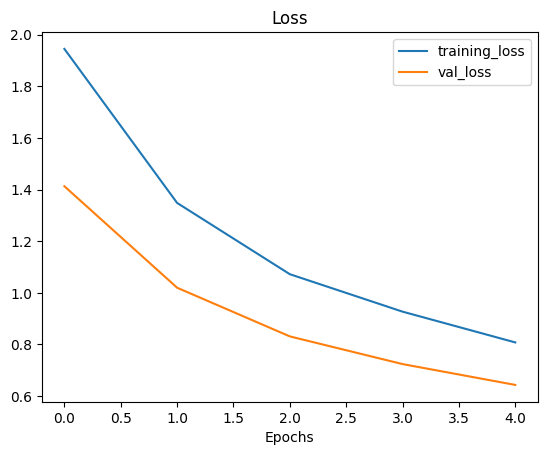

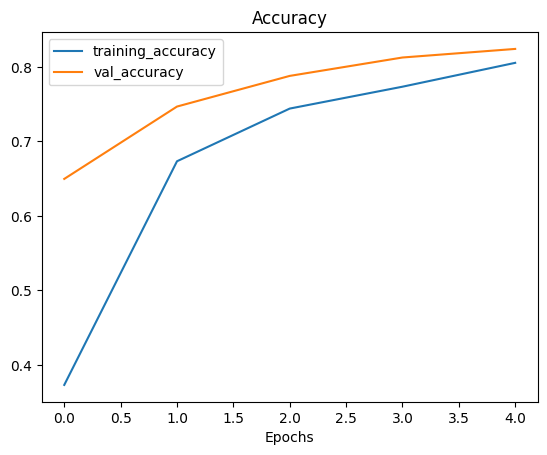

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6535 - accuracy: 0.8160


In [ ]:
result_2 == loaded_weights_model_results

False

In [ ]:
result_2

[0.6534910798072815, 0.8159999847412109]

In [ ]:
loaded_weights_model_results

[0.653491199016571, 0.8159999847412109]

In [ ]:
import numpy as np

np.isclose(np.array(result_2) , np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(result_2) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


## Model 3: Fine-Tuning an existing model on 10% of the data
> **Note:** Fine Tuning usually works best after training a feature extraction model for a few epochs with a large amounts of custom data.


In [ ]:
# Layers is loaded model
model_2.layers


In [ ]:
# Are these trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f43f06f4130> True
<keras.src.engine.sequential.Sequential object at 0x7f43f353c610> True
<keras.src.engine.functional.Functional object at 0x7f43f06f4040> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f43f3971240> True
<keras.src.layers.core.dense.Dense object at 0x7f43f092a410> True


In [ ]:
# What layers are in our base model (EfficientNetV2B0)
for i , layer in enumerate(model_2.layers[2].layers):
  print(i , layer.name ,layer.trainable)

In [ ]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To Begin with Fine-Tuning lets set the last 10 layers of base model "True"

base_model.trainable = True

# Free all layers except for last 10

for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), # When Fine Tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

**Note:** When using fine tunning it's best practise to lower your learning rate by 10x

In [ ]:
# Check which layers are tunable
for layer_number , layer in enumerate(model_2.layers[2].layers):
  print(layer_number , layer.name , layer.trainable)

In [ ]:
# Now we have Un-Frozen last 10 layers
print(len(model_2.layers[2].trainable_variables))

10


In [ ]:
# Fine Tune for another 5 Epochs
fine_tune_epochs = initial_epochs+5

# Refit the model

history_3 = model_2.fit(train_data_10,
                        epochs = 10,
                        validation_data = test_data,
                        validation_steps=int(0.25*len(test_data)),
                        initial_epoch = history_10_percent_data_aug.epoch[-1], # Start training from previous epochs
                        callbacks = [create_tensorboard_callback(dir_name="transfer_learning" , experiment_name="fine_tune_last_10"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/fine_tune_last_10/20231203-150622
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.8147
Epoch 5: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 28s 676ms/step - loss: 0.7054 - accuracy: 0.8147 - val_loss: 0.5504 - val_accuracy: 0.8174
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.8173
Epoch 6: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 519ms/step - loss: 0.6148 - accuracy: 0.8173 - val_loss: 0.5358 - val_accuracy: 0.8224
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.8120
Epoch 7: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 545ms/step - loss: 0.5724 - accuracy: 0.8120 - val_loss: 0.4942 - val_accuracy: 0.8355


In [ ]:
# Evaluate the fine-tuned model
result_3 = model_2.evaluate(test_data)

79/79 [==============================] - 8s 94ms/step - loss: 0.4596 - accuracy: 0.8408


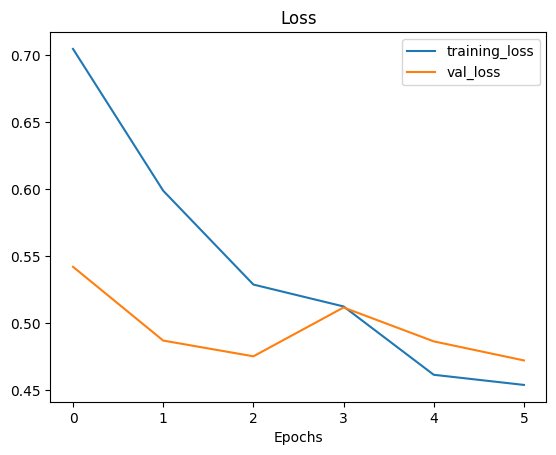

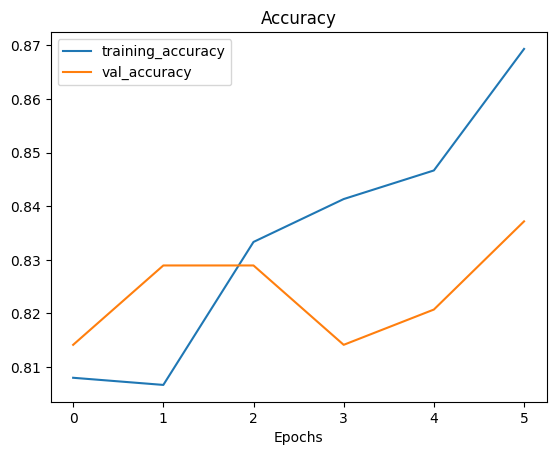

In [ ]:
plot_loss_curves(history_3)

The `plot_loss_curve` function works great with models which have only been fit once , however we want something to compare one series of running `fit()` with another

In [ ]:
def compare_history(org_history , new_history , initial_epochs = 5):
  """
  Compares two TensorFlow History objects.
  """

  # Get original history measurements
  acc = org_history.history["accuracy"]
  loss = org_history.history["loss"]

  val_acc = org_history.history["val_accuracy"]
  val_loss = org_history.history["val_loss"]

  # Combine Original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make Plots
  plt.figure(figsize=(8,8))
  plt.subplot(2 ,1 ,1)
  plt.plot(total_acc , label = "Training Acccuracy")
  plt.plot(total_val_acc , label = "Val Accuracy")

  plt.plot([initial_epochs-1 , initial_epochs-1 ] , plt.ylim() , label="Start Fine Tunning")
  plt.legend(loc = "lower right")


    # Make Plots
  plt.figure(figsize=(8,8))
  plt.subplot(2 ,1 ,2)
  plt.plot(total_loss , label = "Training Loss")
  plt.plot(total_val_loss , label = "Val Loss")

  plt.plot([initial_epochs-1 , initial_epochs-1 ] , plt.ylim() , label="Start Fine Tunning")
  plt.legend(loc = "lower right")

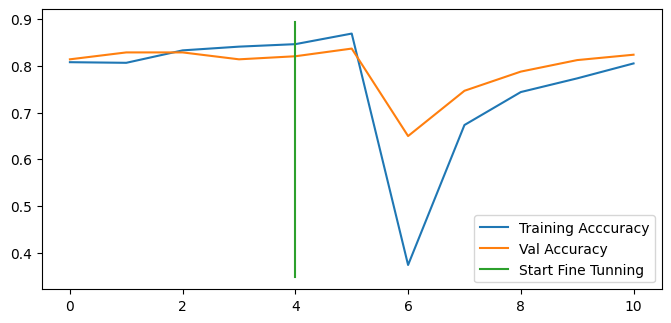

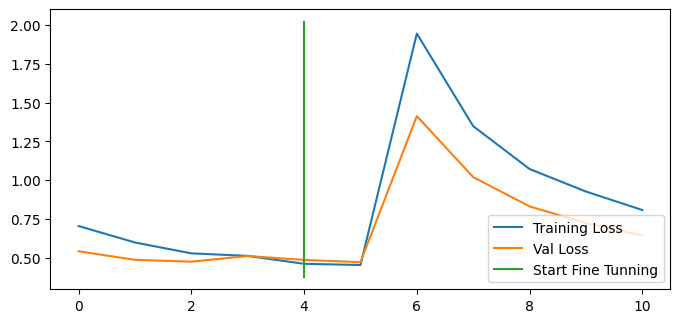

In [ ]:
compare_history(history_3 , history_10_percent_data_aug , initial_epochs = 5)

## Model 4 : Fine-Tuning and Existing Model on all of the Data


In [ ]:
# Download and unzip 10 classes of Food101 data with all images

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-12-03 14:38:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  63.5MB/s    in 6.9s    

2023-12-03 14:38:28 (72.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setting up Training and Testing Directories

train_dir = "10_food_classes_all_data/train/"

test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Exploring data
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 

In [ ]:
# Set-up Data Inputs

import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_whole= tf.keras.preprocessing.image_dataset_from_directory(train_dir ,
                                                                      image_size = IMG_SIZE,
                                                                      label_mode = "categorical",
                                                                      batch_size = 32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode ="categorical",
                                                                batch_size = 32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The Test Dataset is the same as what we have been using through all experiments

In [ ]:
# Evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 8s 85ms/step - loss: 0.6709 - accuracy: 0.8192


[0.6708568930625916, 0.8191999793052673]

To Train a fine-tuning model we need to revert model_2 back to its feature extraction weights

In [ ]:
# Load weights from the checkpoint , that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from

model_2.load_weights(checkpoint_path)

In [ ]:
# Verification
model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6709 - accuracy: 0.8192


[0.6708568930625916, 0.8191999793052673]

In [ ]:
# Check which layers are tunable in whole model

for layer_number , layer in enumerate(model_2.layers):
  print(layer_number , layer.name , layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 pooling_layer True
4 output_layer True


In [ ]:
# Check our Base Model and see what layers are trainable

for layer_number , layer in enumerate(model_2.layers[2].layers):
  print(layer_number , layer.name , layer.trainable)

In [ ]:
# Compile the model

model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics =["accuracy"])



In [ ]:
fine_tune_epochs = initial_epochs+ 5


final_history = model_2.fit(train_data_whole,
                            epochs = fine_tune_epochs,
                            validation_data=test_data,
                            validation_steps = int(0.25*len(test_data)),

                            callbacks=[create_tensorboard_callback( "full_data_transfer_learning" , experiment_name ="final_test")])

Saving TensorBoard log files to: full_data_transfer_learning/final_test/20231203-151147
Epoch 1/10
235/235 [==============================] - 65s 261ms/step - loss: 0.5647 - accuracy: 0.8160 - val_loss: 0.3201 - val_accuracy: 0.9046
Epoch 2/10
235/235 [==============================] - 51s 215ms/step - loss: 0.5144 - accuracy: 0.8280 - val_loss: 0.2743 - val_accuracy: 0.9112
Epoch 3/10
235/235 [==============================] - 51s 215ms/step - loss: 0.4845 - accuracy: 0.8411 - val_loss: 0.2592 - val_accuracy: 0.9211
Epoch 4/10
235/235 [==============================] - 47s 200ms/step - loss: 0.4625 - accuracy: 0.8495 - val_loss: 0.2793 - val_accuracy: 0.9145
Epoch 5/10
235/235 [==============================] - 41s 173ms/step - loss: 0.4271 - accuracy: 0.8612 - val_loss: 0.2246 - val_accuracy: 0.9243
Epoch 6/10
235/235 [==============================] - 38s 160ms/step - loss: 0.4133 - accuracy: 0.8604 - val_loss: 0.2495 - val_accuracy: 0.9145
Epoch 7/10
235/235 [======================

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 10s 116ms/step - loss: 0.2344 - accuracy: 0.9224


[0.23438070714473724, 0.9223999977111816]